In [1]:
import os
import cv2
import numpy as np
from tqdm import tqdm
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense, Input, GlobalAveragePooling2D, Flatten
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from sklearn.model_selection import train_test_split
from IPython.display import clear_output
import random
import shutil

In [2]:
from google.colab import drive
drive.mount("drive")

Mounted at drive


In [3]:
!unzip drive/MyDrive/Datasets/FINAL_COVID_DATASET.zip
clear_output()

In [4]:
def split_data(data_path):
  os.mkdir("dataset")
  os.mkdir("dataset/train")
  os.mkdir("dataset/test")
  os.mkdir("dataset/val")
  for i in os.listdir(data_path):
    os.mkdir(f"dataset/train/{i}")
    os.mkdir(f"dataset/test/{i}")
    os.mkdir(f"dataset/val/{i}")
    cat_path = os.path.join(data_path,i)
    filenames = os.listdir(cat_path)
    random.seed(2021)
    random.shuffle(filenames)
    train, test = train_test_split(filenames, test_size=0.25)
    test, val = train_test_split(test, test_size=0.5)
    for file in tqdm(train):
      shutil.copy(f"{cat_path}/{file}", f"dataset/train/{i}/{file}")
    for file in tqdm(test):
      shutil.copy(f"{cat_path}/{file}", f"dataset/test/{i}/{file}")
    for file in tqdm(val):
      shutil.copy(f"{cat_path}/{file}", f"dataset/val/{i}/{file}")

In [5]:
split_data("FINAL_COVID_DATASET")

100%|██████████| 713/713 [00:00<00:00, 5871.83it/s]


In [6]:
len(os.listdir("dataset/train/COVID"))

3164

In [7]:
IMAGE_SIZE = 224
BATCH_SIZE = 64

generator = ImageDataGenerator(rescale=1./255)
X_train = generator.flow_from_directory(
    "dataset/train",
    target_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

X_test = generator.flow_from_directory(
    "dataset/test",
    target_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

X_val = generator.flow_from_directory(
    "dataset/val",
    target_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)
print("Train:",X_train.class_indices)
print("Test:",X_test.class_indices)
print("Val:",X_val.class_indices)

Found 11094 images belonging to 3 classes.
Found 1849 images belonging to 3 classes.
Found 1850 images belonging to 3 classes.
Train: {'COVID': 0, 'NORMAL': 1, 'PNEUMONIA': 2}
Test: {'COVID': 0, 'NORMAL': 1, 'PNEUMONIA': 2}
Val: {'COVID': 0, 'NORMAL': 1, 'PNEUMONIA': 2}


In [8]:
base_model = DenseNet121(
    input_shape=(IMAGE_SIZE,IMAGE_SIZE,3),
    include_top=False,
    weights='imagenet',
)
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation="relu")(x)
x = Dense(512, activation="relu")(x)
x = Dense(3, activation="softmax")(x)

29097984/29084464 [==============================] - 2s 0us/step


In [9]:
model = Model(inputs=base_model.input, outputs=x)

for layer in model.layers[:30]:
  layer.trainable = False

for layer in model.layers[30:]:
  layer.trainable = True

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                              

In [10]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [11]:
checkpoint_cb = ModelCheckpoint(
    "checkpoint_model.h5",
    monitor='val_loss',
    save_best_only=True,
    verbose=1,
    mode='min'
)
early_stopping_cb = EarlyStopping(
    monitor='val_loss',
    patience=4,
    verbose=1,
    restore_best_weights=True,
    mode='min'
)
reduce_on_plateau_cb = ReduceLROnPlateau(
    monitor='val_loss',
    mode='min',
    verbose=1,
    patience=2,
    factor=0.5,
    min_lr=1e-6
)

In [12]:
with tf.device("/device:GPU:0"):
  history = model.fit_generator(
      X_train,
      validation_data=X_val,
      epochs=50,
      callbacks=[checkpoint_cb, early_stopping_cb, reduce_on_plateau_cb]
  )

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/50
174/174 [==============================] - ETA: 0s - loss: 0.3074 - accuracy: 0.8812
Epoch 00001: val_loss improved from inf to 8.21641, saving model to checkpoint_model.h5
174/174 [==============================] - 243s 1s/step - loss: 0.3074 - accuracy: 0.8812 - val_loss: 8.2164 - val_accuracy: 0.4205 - lr: 0.0010
Epoch 2/50
174/174 [==============================] - ETA: 0s - loss: 0.1850 - accuracy: 0.9274
Epoch 00002: val_loss improved from 8.21641 to 1.76629, saving model to checkpoint_model.h5
174/174 [==============================] - 207s 1s/step - loss: 0.1850 - accuracy: 0.9274 - val_loss: 1.7663 - val_accuracy: 0.7054 - lr: 0.0010
Epoch 3/50
174/174 [==============================] - ETA: 0s - loss: 0.1574 - accuracy: 0.9406
Epoch 00003: val_loss did not improve from 1.76629
174/174 [==============================] - 205s 1s/step - loss: 0.1574 - accuracy: 0.9406 - val_loss: 8.4349 - val_accuracy: 0.3789 - lr: 0.0010
Epoch 4/50
174/174 [==========================

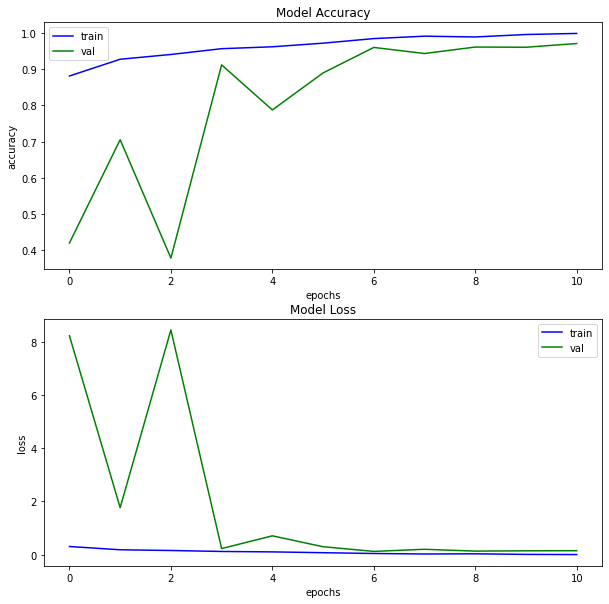

In [15]:
plt.figure(figsize=(10,10))
for i, met in enumerate(['accuracy', 'loss']):
  plt.subplot(2,1,i+1)
  plt.plot(history.history[met], color="b")
  plt.plot(history.history["val_"+met], color="g")
  plt.title('Model '+met.capitalize())
  plt.xlabel('epochs')
  plt.ylabel(met)
  plt.legend(['train', 'val'])
  # plt.axvline(x=6, label=f"line at x = {6}", c='r',ls="--", lw=1)

In [16]:
model.evaluate(X_test)

29/29 [==============================] - 13s 449ms/step - loss: 0.1552 - accuracy: 0.9567


[0.15522512793540955, 0.9567333459854126]

In [17]:
cp_model = tf.keras.models.load_model("checkpoint_model.h5")
cp_model.evaluate(X_test)

29/29 [==============================] - 13s 367ms/step - loss: 0.1552 - accuracy: 0.9567


[0.15522514283657074, 0.9567333459854126]

In [18]:
model.save("model.h5")

In [19]:
!cp model.h5 drive/MyDrive/Covid-Pneumonia_Detection_Model/Transfer_Learning/densenet121.h5

In [20]:
import pickle
with open('DenseNet121trainHistory', 'wb') as file_pi:
        pickle.dump(history.history, file_pi)
# To load history
# history = pickle.load(open('DenseNet121trainHistory', "rb"))

In [21]:
!cp DenseNet121trainHistory drive/MyDrive/Covid-Pneumonia_Detection_Model/Transfer_Learning/DenseNet121trainHistory